# Adversarial Robustness Toolkit

* Documentación: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
* Código: https://github.com/Trusted-AI/adversarial-robustness-toolbox
* Ejemplos: https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/examples

## Instalación

In [ ]:
!pip install adversarial-robustness-toolbox==1.8.1

     |████████████████████████████████| 1.1 MB 11.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.6 MB/s 
     |████████████████████████████████| 26.3 MB 91 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
from art.utils import load_mnist

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

## Cargar datos

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print("min_pixel_value:", min_pixel_value)
print("min_pixel_value:", max_pixel_value)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)
min_pixel_value: 0.0
min_pixel_value: 1.0


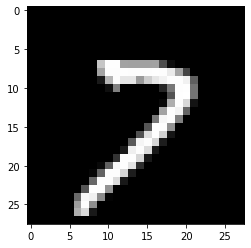

In [ ]:
sample = 567
plt.imshow(x_train[sample].reshape((28, 28)), cmap='gray', interpolation='none')

## Entrenar modelo

In [ ]:
from art.estimators.classification import KerasClassifier

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

classifier.fit(x_train, y_train, batch_size=128, nb_epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 560us/sample - loss: 0.2205 - accuracy: 0.9340
Epoch 2/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0624 - accuracy: 0.9811
Epoch 3/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0456 - accuracy: 0.9858
Epoch 4/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0365 - accuracy: 0.9889
Epoch 5/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0294 - accuracy: 0.9906
Epoch 6/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0257 - accuracy: 0.9919
Epoch 7/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0213 - accuracy: 0.9930
Epoch 8/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0194 - accuracy: 0.9938
Epoch 9/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0166 - accuracy: 0.9946
Epoch 10/10


In [ ]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {:.2f}%".format(accuracy * 100))

Accuracy on test examples: 99.21%


# Ataque de inversión

In [ ]:
from art.attacks.inference.model_inversion import MIFace

In [ ]:
y = np.arange(10)

In [ ]:
attack = MIFace(classifier, max_iter=10000, threshold=0.99)

In [ ]:
x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

x_inits = [x_init_white, x_init_grey, x_init_black, x_init_random, x_init_average]
x_inits_names = ["white", "grey", "black", "random", "average"]

In [ ]:
x_infers = []
for x in x_inits:
  x_infers.append(attack.infer(x, y))

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

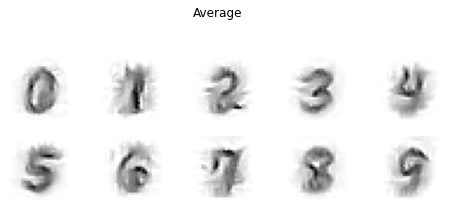

In [ ]:
plt.figure(figsize=(8,7))
plt.suptitle("Average")
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_infers[4][i].reshape((28, 28)), cmap='gray_r') # Average
    plt.axis("off")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

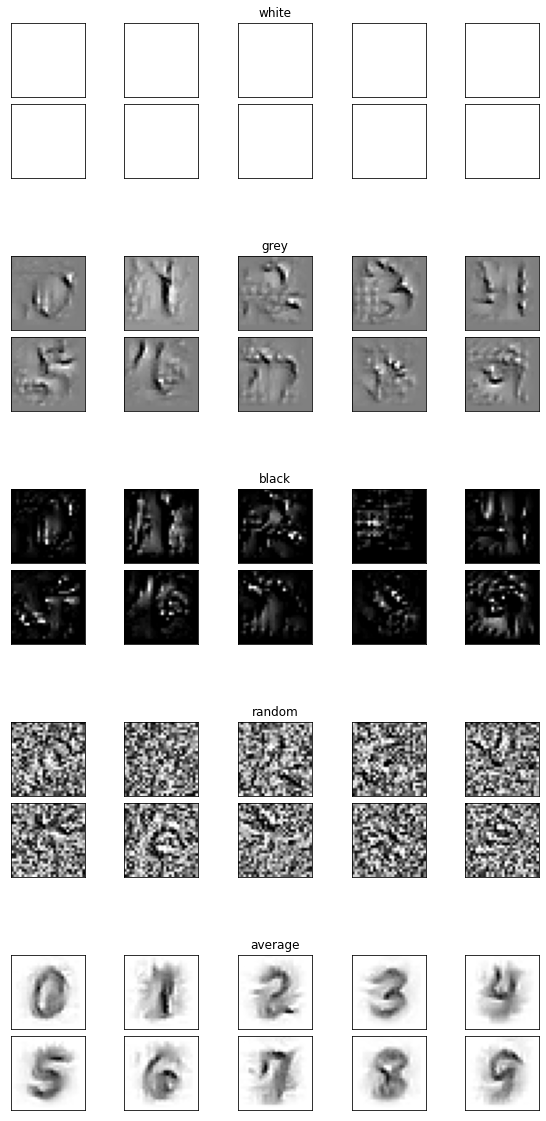

In [ ]:
fig = plt.figure(figsize=(10, 20))
outer = gridspec.GridSpec(5, 1, hspace=0.5)

for i, x_infer in enumerate(x_infers):
    inner = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(10):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(x_infers[i][j].reshape((28, 28)), cmap='gray_r')
        
        if j == 2:
          ax.set_title(x_inits_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()